# Task 3: LambdaMART Model

## Imports and Installs

In [52]:
# !pip install xgboost

In [53]:
from nltk.stem import WordNetLemmatizer
import contractions
import string
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import bcolz
from numpy import dot
from numpy.linalg import norm

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [54]:
def normalise(text):
    '''
    Function that normalises text and returns tokens.
    Input: text --> text string we want to tokenise
    Output: tokens --> list of tokens taken from the text string
    '''

    text = text.lower() # convert all to lower case
    text = contractions.fix(text) # expand contractions
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) # remove punctuation
    tokens = text.split() # tokenisation
    filtered_tokens = [w for w in tokens if not w in stop_words] # remove stop words
    # filtered_tokens = list(map(lemmatizer.lemmatize, filtered_tokens)) # lemmatization of nouns

    return filtered_tokens

In [55]:
#Load in pickled embeddings
vectors = bcolz.open('6B.50.dat')[:]
words = pickle.load(open('6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open('6B.50_idx.pkl', 'rb'))
glove = {w: vectors[word2idx[w]] for w in words}

## Import BM25 and TF-IDF scores

In [56]:
bm25_train = pd.read_csv('bm25_train.csv', delimiter=',', header=None, names=['qid','pid','bm25'])
tfidf_train = pd.read_csv('tfidf_train.csv', delimiter=',', header=None, names=['qid','pid','tfidf'])

In [57]:
bm25_val = pd.read_csv('bm25_val.csv', delimiter=',', header=None, names=['qid','pid','bm25'])
tfidf_val = pd.read_csv('tfidf_val.csv', delimiter=',', header=None, names=['qid','pid','tfidf'])

## Process data

In [58]:
train_dataframe = pd.read_csv('train_data.tsv', delimiter='\t')
train_dataframe = train_dataframe.join(bm25_train['bm25'])
train_dataframe = train_dataframe.join(tfidf_train['tfidf'])

In [59]:
val_dataframe = pd.read_csv('validation_data.tsv', delimiter='\t')
val_dataframe = val_dataframe.join(bm25_val['bm25'])
val_dataframe = val_dataframe.join(tfidf_val['tfidf'])

In [60]:
X_data_train = []
y_data_train = []

def train_data_extraction(row):

    q_embed = np.zeros(50) # we chose glove vectors to have length = 50
    p_embed = np.zeros(50)
    
    query = normalise(row['queries'])
    for q in query:
        try:
            q_embed += glove[q]
        except:
            q_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    q_embed /= len(query)

    passage = normalise(row['passage'])
    for p in passage:
        try:
            p_embed += glove[p]
        except:
            p_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    p_embed /= len(passage)

    rel = row['relevancy']
    
    sim = dot(q_embed, p_embed) / (norm(q_embed) * norm(p_embed))
    bm25_score = row['bm25']
    tfidf_score = row['tfidf']
    q_len = len(query)
    p_len = len(passage)

    X_data_train.append([sim, bm25_score, tfidf_score, q_len, p_len])
    y_data_train.append(rel)

_ = train_dataframe.apply(lambda row: train_data_extraction(row), axis=1)

X_data_train = np.array(X_data_train, dtype="O")
y_data_train = np.array(y_data_train, dtype="O")

In [61]:
# Save processed training data to use in NN model in Task 4
np.savetxt('processed_X_train_data.txt', X_data_train, fmt='%f')
np.savetxt('processed_y_train_data.txt', y_data_train, fmt='%f')

In [62]:
X_data_val = []
y_data_val = []

def val_data_extraction(row):

    q_embed = np.zeros(50) # we chose glove vectors to have length = 50
    p_embed = np.zeros(50)
    
    query = normalise(row['queries'])
    for q in query:
        try:
            q_embed += glove[q]
        except:
            q_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    q_embed /= len(query)

    passage = normalise(row['passage'])
    for p in passage:
        try:
            p_embed += glove[p]
        except:
            p_embed += glove['<unk>'] # if the token is not present in GloVe, we assign it as <unk>
    p_embed /= len(passage)

    rel = row['relevancy']
    
    sim = dot(q_embed, p_embed) / (norm(q_embed) * norm(p_embed))
    bm25_score = row['bm25']
    tfidf_score = row['tfidf']
    q_len = len(query)
    p_len = len(passage)

    X_data_val.append([sim, bm25_score, tfidf_score, q_len, p_len])
    y_data_val.append(rel)

_ = val_dataframe.apply(lambda row: val_data_extraction(row), axis=1)

X_data_val = np.array(X_data_val, dtype="O")
y_data_val = np.array(y_data_val, dtype="O")

In [116]:
# Save processed validation data to use in NN model in Task 4
np.savetxt('processed_X_val_data.txt', X_data_val, fmt='%f')
np.savetxt('processed_y_val_data.txt', y_data_val, fmt='%f')

## Prepare data for cross validation

In [64]:
qid_pid = []

def get_qid_pid(row):

    qid = row['qid']
    pid = row['pid']

    qid_pid.append([qid,pid])

_ = train_dataframe.apply(lambda row: get_qid_pid(row), axis=1)

qid_pid = np.array(qid_pid)

In [65]:
# Put the qid pid references in the array, so that when we do the tune split, we keep them and we can caluclate the ndcg scores
y_data_train = np.concatenate((np.array([y_data_train]).T,qid_pid),axis=1)

## Build LambdaMART model

For LambdaMART we set objective to rank:pairwise, rank:ndcg, or rank:map.

Here we parameterise the model and we do hyperparameter tuning to derive the best performing model.

Main hyperparameters to focus on:

Control overfitting with model complexity:

- max_depth (maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth --> default = 6, range from 0 to +infinity)
- min_child_weight (Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be --> default = 1, range from 0 to +infinity)
- gamma (minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be --> detault = 0, rages from 0 to +infinity)
- Regularisation with lambda (L2 regularization term on weights. Increasing this value will make model more conservative --> default = 1)
- Regularisation with alpha (L1 regularization term on weights. Increasing this value will make model more conservative --> default = 0)

Control overfitting by adding randomness:

- subsample (Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration --> default = 1, range (0,1])
- colsample_bytree
- Reduce stepsize (eta --> default = 0.3, ranges from 0 to 1) and increase num_round (number of rounds for boosting)

For faster training performance:

- Set tree_method (default = auto) to hist or gpu_hist



### 1) Prepare data for training and hyperparameter tuning

In [66]:
# Separate training data 90% training, 10% for testing (hyperparameter tuning)
X_train, X_tune, yplus_train, yplus_tune = train_test_split(X_data_train,y_data_train,test_size=.1, random_state=42)

In [67]:
y_train = yplus_train[:,0]
# qid_pid_train = yplus_train[:,1:] # not necessary

y_tune = yplus_tune[:,0]
qid_pid_tune = yplus_tune[:,1:]

In [68]:
# Create DMatrix
train_data = xgb.DMatrix(X_train, label=y_train)
tune_data = xgb.DMatrix(X_tune, label=y_tune)
val_data = xgb.DMatrix(X_data_val, label=y_data_val)

### 2) mNDCG calculator function for tuning data

In [69]:
# NDCG function
def mNDCG_tune(ranking, relevancies, k):
    '''
    Function that computes the Normalized Discounted Cumulative Gain (NDCG) metric for each query in 'queries', 
    based on a ranking determined by a retrieval model, where queries are matched with passages from most relevant 
    to least relevant, and based on relevancies between queries and passages.

    Inputs:
    ranking = array of (qid,pid,score)
    relevancies = array of relevancies between each possible (qid,pid) pair
    k = top k passages you want to take into account when calculating the AP metric

    Outputs:
    NDCGs = list of NDCG@k metric for each query, in the same order of appearance as the input list 'queries'
    mNDCG = mean NDCG@k of all the queries
    '''

    queries = np.unique(ranking[:,0])

    NDCGs = []

    for q in queries:
        relevant_pairs = ranking[ranking[:,0]==q]
        relevant_rels = relevancies[ranking[:,0]==q]
        indxs = np.argsort(relevant_pairs[:,2])[::-1]
        rel_ranking = relevant_rels[indxs]
        ideal_ranking = np.sort(rel_ranking)[::-1]

        DCG = 0
        IDCG = 0

        max_k = len(relevant_rels)
        iter = min(k,max_k) # This is because we some queries do not have that many candidate passages

        for i in range(1,iter+1):
            IDCG += (2**ideal_ranking[i-1] - 1)/np.log2(i+1)
            DCG += (2**rel_ranking[i-1] - 1)/np.log2(i+1)

        if IDCG != 0:
            NDCGs.append(DCG/IDCG)
        else: # we do this to avoid the computing error of dividing 0/0
            NDCGs.append(0)

    mNDCG = np.mean(NDCGs)

    return mNDCG

### 3) Hyperparameter tuning
The optimal way to do it would be with a massive grid search with all the parameters, but we do not have time nor computing power for that, so we focus in the most imoprtant parameters that have the most effect on a model.

In [70]:
# Initial parameters of the model
params = {
    # Parameters that we are going to tune.
    'max_depth':6, # try values: 8 to 11
    'min_child_weight': 1, # try values 4 to 7
    'eta':0.3, # try values [.3, .2, .1, .05, .01, .005]
    # 'num_round':10, # try values [10, 20, 30, .50, .100, .300]
    'subsample': 1, # try values [0.7, 0.8, 0.9, 1] - proportion of data samples we use
    'colsample_bytree': 1, # try values [0.7, 0.8, 0.9, 1] - proportion of features we use
    # Other parameters
    'objective':'rank:pairwise',
}

#### 3.1) max_depth vs min_child_weight

In [71]:
max_depths = [8,9,10,11]
min_child_weights = [4,5,6,7]

In [72]:
mNDCGs = np.zeros([len(max_depths), len(min_child_weights)])

for i in range(len(max_depths)):
    for j in range(len(min_child_weights)):
        
        params = {'max_depth':max_depths[i], 'min_child_weight': min_child_weights[j], 'eta':0.3, 
                    'subsample': 1, 'colsample_bytree': 1, 'objective':'rank:pairwise'}
        
        # Train model with chosen parameters
        model = xgb.train(params, train_data)

        # Make predictions with the trained model
        preds = model.predict(tune_data)

        # Get true labels trom tuning data
        tuning_labels = tune_data.get_label()

        # Evaluate predictions: compute mNDCG of tuning data
        # Note that for the NDCG function we put preds as the score in the ranking array, and tuning_labels are the relevancies
        ranking_array = np.concatenate((qid_pid_tune,np.array([preds]).T), axis=1)
        mNDCGs[i,j] = mNDCG_tune(ranking_array, tuning_labels, 100)

In [73]:
coords = np.argwhere(mNDCGs == np.min(mNDCGs))
best_max_depth = max_depths[coords[0,0]]
best_min_child_weight = min_child_weights[coords[0,1]]

In [74]:
print(best_max_depth)
print(best_min_child_weight)

11
7


#### 3.2) subsample vs colsample_bytree

In [75]:
subsamples = [0.7,0.8,0.9,1]
colsample_bytrees = [0.7,0.8,0.9,1]

In [76]:
mNDCGs = np.zeros([len(subsamples), len(colsample_bytrees)])

for i in range(len(subsamples)):
    for j in range(len(colsample_bytrees)):
        
        params = {'max_depth':best_max_depth, 'min_child_weight': best_min_child_weight, 'eta':0.3, 
                    'subsample': subsamples[i], 'colsample_bytree': colsample_bytrees[j], 'objective':'rank:pairwise'}
        
        # Train model with chosen parameters
        model = xgb.train(params, train_data)

        # Make predictions with the trained model
        preds = model.predict(tune_data)

        # Get true labels trom tuning data
        tuning_labels = tune_data.get_label()

        # Evaluate predictions: compute mNDCG of tuning data
        # Note that for the NDCG function we put preds as the score in the ranking array, and tuning_labels are the relevancies
        ranking_array = np.concatenate((qid_pid_tune,np.array([preds]).T), axis=1)
        mNDCGs[i,j] = mNDCG_tune(ranking_array, tuning_labels, 100)

In [77]:
coords = np.argwhere(mNDCGs == np.min(mNDCGs))
best_subsample = subsamples[int(coords[0,0])]
best_colsample_bytree = colsample_bytrees[int(coords[0,1])]

In [78]:
print(best_subsample)
print(best_colsample_bytree)

0.7
0.7


#### 3.3) eta

In [79]:
etas = [.3, .2, .1, .05, .01, .005]

In [80]:
mNDCGs = np.zeros(len(etas))

for i in range(len(etas)):
        
    params = {'max_depth':best_max_depth, 'min_child_weight': best_min_child_weight, 'eta':etas[i], 
                'subsample': best_subsample, 'colsample_bytree': best_colsample_bytree, 'objective':'rank:pairwise'}
    
    # Train model with chosen parameters
    model = xgb.train(params, train_data)

    # Make predictions with the trained model
    preds = model.predict(tune_data)

    # Get true labels trom tuning data
    tuning_labels = tune_data.get_label()

    # Evaluate predictions: compute mNDCG of tuning data
    # Note that for the NDCG function we put preds as the score in the ranking array, and tuning_labels are the relevancies
    ranking_array = np.concatenate((qid_pid_tune,np.array([preds]).T), axis=1)
    mNDCGs[i] = mNDCG_tune(ranking_array, tuning_labels, 100)

In [81]:
coords = np.argmin(mNDCGs)
best_eta = etas[int(coords)]

In [82]:
print(best_eta)

0.005


### 4) Train final model and get validation ranking

In [97]:
# Final parameters
params = {'max_depth':11, 'min_child_weight': 7, 'eta':0.005, 
                'subsample': 0.7, 'colsample_bytree': 0.7, 'objective':'rank:pairwise'}

In [98]:
# Tain model on the full training set
train_data = xgb.DMatrix(X_data_train, label=y_data_train[:,0])
model = xgb.train(params, train_data)

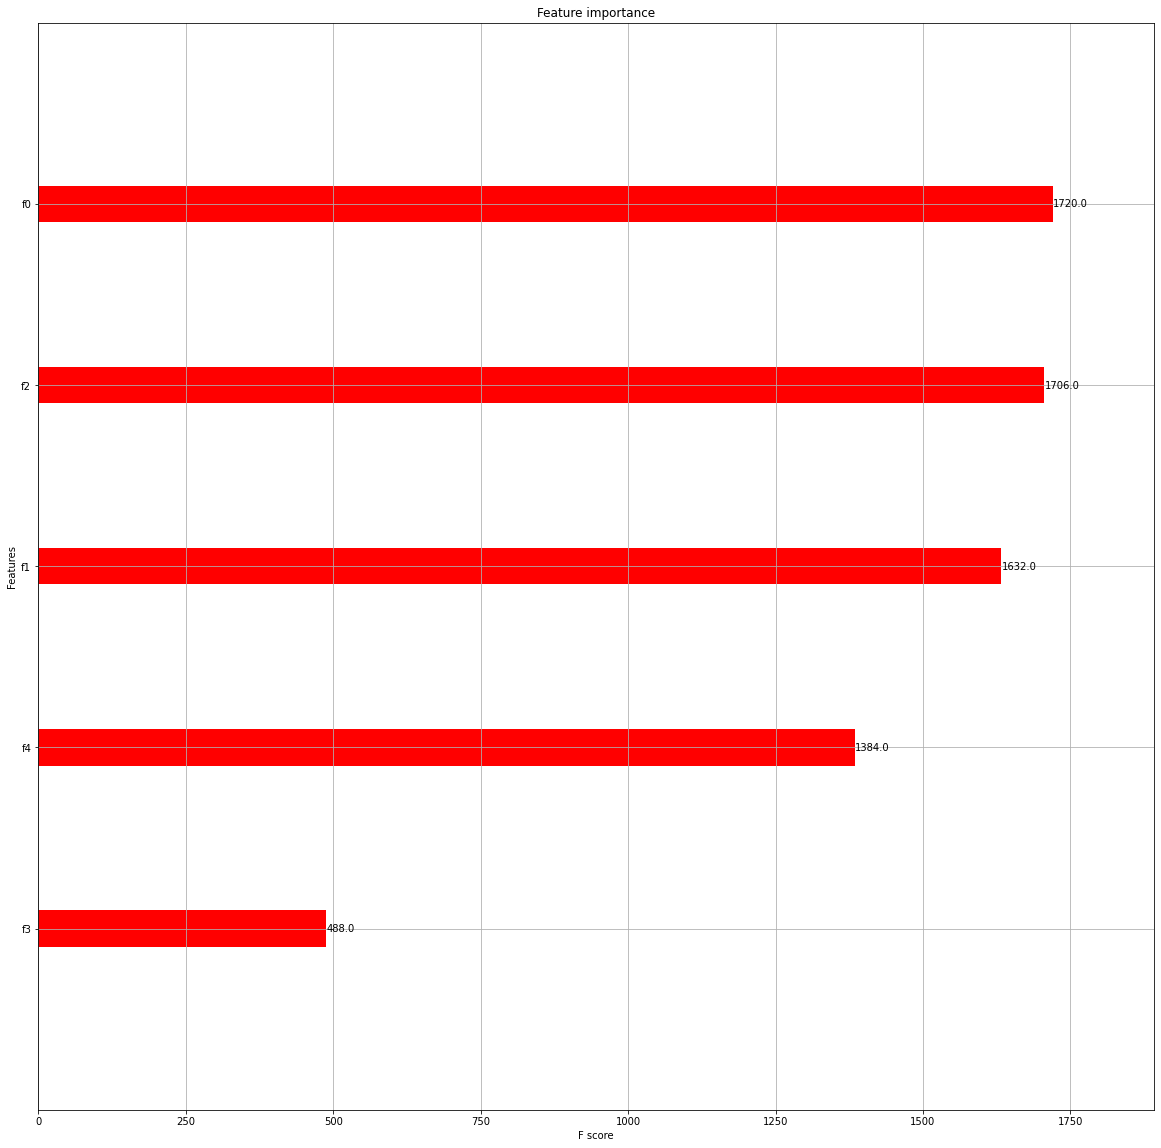

In [99]:
# Look at the importance of each of the features within the model
ax = xgb.plot_importance(model, color='red')
fig = ax.figure
fig.set_size_inches(20, 20)
fig.savefig('feature_importance.png')

## Validation performance analysis

In [100]:
# Make predictions with the trained model
preds = model.predict(val_data)

### Make ranking

In [101]:
y_pred_val = preds

In [102]:
# Export LM.txt ranking

unique_qids = val_dataframe['qid'].copy()
unique_qids = unique_qids.drop_duplicates()
unique_qids = unique_qids.reset_index(drop=True)
unique_qids = np.array(unique_qids) # vector of unique qid in the validation set

qid_pid_val = val_dataframe[['qid','pid']].copy()
qid_pid_val = np.array(qid_pid_val) # (n,2) array, where each row corresponds to the (qid, pid) pair of each sample

In [103]:
LM_scores = pd.DataFrame(columns=['qid', 'A', 'pid', 'rank', 'score', 'algoname']) # dataframe where we store global results for all queries

for qid in unique_qids:
    output_info = pd.DataFrame(columns=['qid', 'A', 'pid', 'rank', 'score', 'algoname']) # dataframe where we store 
                                                                                         # the results for the current query
    qid_pairs = qid_pid_val[qid_pid_val[:,0] == qid]
    qid_rels = y_pred_val[qid_pid_val[:,0] == qid]
    indxs = np.argsort(qid_rels)[::-1]
    sorted_qid_pairs = qid_pairs[indxs]
    sorted_qid_rels = qid_rels[indxs]
    
    # Now we just get the top 100 scores (if they are available)
    top_sorted_qid_pairs = sorted_qid_pairs[:100,:]
    top_sorted_qid_rels = sorted_qid_rels[:100]

    # Prepare the array with 'A2'
    A2 = np.array(['A2'] * len(top_sorted_qid_rels))

    # Prepare the array with the ranks
    rank = np.array(range(1,len(top_sorted_qid_rels)+1))

    # Prepare the array with the algonamme 'LR'
    algoname = np.array(['LM'] * len(top_sorted_qid_rels))

    # Put everything together in the output_info dataframe
    output_info['qid'] = top_sorted_qid_pairs[:,0]
    output_info['A'] = A2
    output_info['pid'] = top_sorted_qid_pairs[:,1]
    output_info['rank'] = rank
    output_info['score'] = top_sorted_qid_rels
    output_info['algoname'] = algoname

    # Append this query dataframe to the one with global results
    LM_scores = LM_scores.append(output_info, ignore_index=True)

In [104]:
# Save ranking file as LM.txt
np.savetxt(r'LM.txt', LM_scores.values, fmt=['%d','%s','%d','%d','%f','%s'])

### Assess performance of model on validation data
For this part we use the mAP and NDCG functions defiend in Task 1

In [105]:
# Set up dataframes for the functions
tq = val_dataframe[['qid', 'queries']].copy()
tq = tq.drop_duplicates()
tq = tq.reset_index(drop=True)

relevancies = val_dataframe[['qid', 'pid', 'relevancy']].copy()

In [117]:
# Load ranking data created in previous part
LM_ranking = pd.read_csv('LM.txt', delimiter=' ', header=None, names=['qid', 'A', 'pid', 'rank', 'score', 'algoname'])
ranking = LM_ranking[['qid', 'pid', 'score']].copy()

Now copy the AP and NDCG functions from Task 1

In [107]:
# mAP function
def AP(queries, ranking, relevancies, k):
    '''
    Function that computes the Average Precision (AP) metric for each query in 'queries', based on a ranking determined by 
    a retrieval model, where queries are matched with passages from most relevant to least relevant, and based on relevancies 
    between queries and passages.

    Inputs:
    queries = data frame of queries for which you want to calculate the AP metric (contains qid and actual query)
    ranking = data frame of queries and passages pairs, where higher score pairs are ranked higher (for each query)
    relevancies = data frame of relevancies between each possible (qid,pid) pair
    k = top k passages you want to take into account when calculating the AP metric

    Outputs:
    APs = list of AP@k metric for each query, in the same order of appearance as the input list 'queries'
    mAP = mean Average Precision of all the queries
    '''

    APs = []

    for q in queries['qid']:
        AP_values = []
        cum_rel = 0 # cumulative number of relevant passages found in the ranking

        max_k = len(ranking[ranking['qid'] == q])
        iter = min(k,max_k) # This is because we some queries do not have that many candidate passages

        for i in range(1,iter+1):
            p = int(ranking[ranking['qid'] == q].reset_index(drop=True).iloc[i-1]['pid'])
            relevancy = relevancies[(relevancies['qid'] == q) & (relevancies['pid'] == p)]['relevancy'].values.item()
            if relevancy != 0: # we operate when we encounter a relevant passage
                cum_rel += relevancy
                AP_values.append(cum_rel / i) 

        if len(AP_values) != 0:    
            APs.append(sum(AP_values)/len(AP_values))
        else: # we do this to avoid the computing error of dividing 0/0
            APs.append(0)

    mAP = np.mean(APs)

    return APs, mAP

In [108]:
# NDCG function
def NDCG(queries, ranking, relevancies, k):
    '''
    Function that computes the Normalized Discounted Cumulative Gain (NDCG) metric for each query in 'queries', 
    based on a ranking determined by a retrieval model, where queries are matched with passages from most relevant 
    to least relevant, and based on relevancies between queries and passages.

    Inputs:
    queries = data frame of queries for which you want to calculate the AP metric (contains qid and actual query)
    ranking = data frame of queries and passages pairs, where higher score pairs are ranked higher (for each query)
    relevancies = data frame of relevancies between each possible (qid,pid) pair
    k = top k passages you want to take into account when calculating the AP metric

    Outputs:
    NDCGs = list of AP@k metric for each query, in the same order of appearance as the input list 'queries'
    mNDCG = mean Average Precision of all the queries
    '''

    NDCGs = []

    for q in queries['qid']:
        DCG = 0
        IDCG = 0

        max_k = len(ranking[ranking['qid'] == q])
        iter = min(k,max_k) # This is because we some queries do not have that many candidate passages

        # Get the relevancies for the ideal ranking (of the top k candidates??? - doesn't matter for our data tho), in order
        sorted_revs = relevancies[relevancies['qid'] == q].sort_values(by=['relevancy'], ascending=False)['relevancy'].values

        for i in range(1,iter+1):
            IDCG += (2**sorted_revs[i-1] - 1)/np.log2(i+1)

            p = int(ranking[ranking['qid'] == q].reset_index(drop=True).iloc[i-1]['pid'])
            rel = relevancies[(relevancies['qid'] == q) & (relevancies['pid'] == p)]['relevancy'].values.item()
            DCG += (2**rel - 1)/np.log2(i+1)

        if IDCG != 0:
            NDCGs.append(DCG/IDCG)
        else: # we do this to avoid the computing error of dividing 0/0
            NDCGs.append(0)

    mNDCG = np.mean(NDCGs)

    return NDCGs, mNDCG

Compute performance metrics

In [118]:
AP_3, mAP_3 = AP(tq, ranking, relevancies, 3)
AP_10, mAP_10 = AP(tq, ranking, relevancies, 10)
AP_100, mAP_100 = AP(tq, ranking, relevancies, 100)

NDCG_3, mNDCG_3 = NDCG(tq, ranking, relevancies, 3)
NDCG_10, mNDCG_10 = NDCG(tq, ranking, relevancies, 10)
NDCG_100, mNDCG_100 = NDCG(tq, ranking, relevancies, 100)

In [119]:
print(mAP_3, mAP_10, mAP_100)

print(mNDCG_3, mNDCG_10, mNDCG_100)

0.1476480836236934 0.17821781151484983 0.19153942472237973
0.1623404784203946 0.22750182841012126 0.30431658062579914
